In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jsonali2003_luna_16_path = kagglehub.dataset_download('jsonali2003/luna-16')

print('Data source import complete.')


In [ ]:
import SimpleITK as sitk
import pandas as pd
import numpy as np
import os
import time
import gc
import random
from glob import glob
from scipy.ndimage import zoom, binary_dilation, generate_binary_structure
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Optional: Monitor GPU
!pip install GPUtil
try:
    import GPUtil
except ImportError:
    print("GPUtil not found. Cannot monitor GPU usage.")
    GPUtil = None

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=2394b57872e53baf7cb2e8c019ffa469a09675f78f22a035310c585abb77bf1a
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [ ]:
LUNA16_DATA_PATH = '/kaggle/input/luna-16/Dataset' # Example path
CSV_PATH = os.path.join(LUNA16_DATA_PATH, '/kaggle/input/luna-16/Dataset/')
#SUBSET_PATHS = [os.path.join(LUNA16_DATA_PATH, f'subset{i}/subset{i}') for i in range(1)] # Use only subset0 for speed
SUBSET_PATHS = [os.path.join(LUNA16_DATA_PATH, f'subset{i}/subset{i}') for i in [9]]
print(SUBSET_PATHS)

['/kaggle/input/luna-16/Dataset/subset9/subset9']


In [ ]:
# Preprocessing Parameters
TARGET_SPACING = [1.0, 1.0, 1.0]  # Target isotropic spacing in mm
CLIP_BOUNDS = [-1200, 600]       # HU clipping range
NORM_BOUNDS = [0.0, 1.0]         # Normalization range
PATCH_SIZE = [96, 96, 96]        # Input patch size for the model (z, y, x)
CENTER_SIZE = [48, 48, 48]       # Size of the central region for positive labels in heatmap
OUTPUT_STRIDE = 4                # Strides of the network influence output size

# Training Parameters
BATCH_SIZE = 2                  # Adjust based on GPU memory
LEARNING_RATE = 1e-4
NUM_EPOCHS = 3                   # Keep low for demonstration
VAL_SPLIT = 0.1                 # Use 10% of scans for validation
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Candidate Generation Parameters
DETECTION_THRESHOLD = 0.7       # Minimum probability for a peak to be considered a candidate
NMS_THRESHOLD_VOXELS = 10       # Minimum distance (in voxels) between candidates after NMS

print(f"Using device: {DEVICE}")
if GPUtil and DEVICE.type == 'cuda':
    GPUtil.showUtilization()

Using device: cuda
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [ ]:
def load_scan(path):
    """Loads a CT scan (MHD/RAW format)."""
    return sitk.ReadImage(path)

def get_voxel_coords(scan, world_coords):
    """Converts world coordinates (mm) to voxel coordinates."""
    origin = np.array(scan.GetOrigin())
    spacing = np.array(scan.GetSpacing())
    voxel_coords = (np.array(world_coords) - origin) / spacing
    return tuple(int(round(c)) for c in voxel_coords) # Z, Y, X order expected by ITK

def world_to_voxel(world_coords, origin, spacing):
    """Converts world coordinates (X, Y, Z) to voxel coordinates (z, y, x)"""
    stretched_voxel_coords = np.absolute(world_coords - origin)
    voxel_coords = stretched_voxel_coords / spacing
    return np.round(voxel_coords).astype(int)[::-1] # Reverse to z, y, x

def voxel_to_world(voxel_coords, origin, spacing):
    """Converts voxel coordinates (z, y, x) to world coordinates (X, Y, Z)"""
    stretched_voxel_coords = voxel_coords * spacing[::-1] # Multiply by z,y,x spacing
    world_coords = stretched_voxel_coords + origin[::-1] # Add z,y,x origin
    return world_coords[::-1] # Return as X, Y, Z

def resample_scan(scan, target_spacing=[1.0, 1.0, 1.0]):
    """Resamples a scan to a target spacing."""
    original_spacing = scan.GetSpacing()
    original_size = scan.GetSize()

    new_shape = [int(round(original_size[i] * (original_spacing[i] / target_spacing[i]))) for i in range(3)]

    resample_filter = sitk.ResampleImageFilter()
    resample_filter.SetSize(new_shape)
    resample_filter.SetOutputSpacing(target_spacing)
    resample_filter.SetInterpolator(sitk.sitkLinear) # Use linear interpolation
    resample_filter.SetOutputOrigin(scan.GetOrigin())
    resample_filter.SetOutputDirection(scan.GetDirection())

    resampled_scan = resample_filter.Execute(scan)
    return resampled_scan

def normalize_hu(image_array, clip_bounds, norm_bounds):
    """Normalizes HU values."""
    image_array = np.clip(image_array, clip_bounds[0], clip_bounds[1])
    image_array = (image_array - clip_bounds[0]) / (clip_bounds[1] - clip_bounds[0])
    image_array = image_array * (norm_bounds[1] - norm_bounds[0]) + norm_bounds[0]
    return image_array.astype(np.float32)

def create_lung_mask(image_array, threshold=-400):
    """Creates a rough lung mask using thresholding and morphological operations."""
    # 1. Thresholding
    binary_image = image_array < threshold

    # 2. Connected Components
    label_image = label(binary_image)

    # 3. Identify Air Pockets (exclude trachea, main bronchi)
    # Find the largest region not touching the borders
    # (Assuming lungs are largest regions not touching image boundaries)
    # This is a simplified approach; LUNA16 often provides masks
    background_label = label_image[0, 0, 0] # Label of border pixel
    filled_labels = np.unique(label_image)
    region_areas = [np.sum(label_image == l) for l in filled_labels if l != background_label]

    if not region_areas: # Handle empty mask case
        return binary_image # Return original threshold if no regions found

    # Find the two largest regions (usually the lungs)
    sorted_indices = np.argsort(region_areas)[::-1]
    lung_labels = []
    if len(sorted_indices) > 0:
        lung_labels.append(filled_labels[sorted_indices[0]+1]) # +1 because we skipped background
    if len(sorted_indices) > 1:
        lung_labels.append(filled_labels[sorted_indices[1]+1])

    lung_mask = np.zeros_like(binary_image)
    for ll in lung_labels:
        lung_mask[label_image == ll] = True


    # 4. Morphological Closing (fill holes)
    struct = ball(5)  # Structuring element
    lung_mask = binary_closing(lung_mask, footprint=struct)  # FIXED: use `footprint`

    return lung_mask

In [ ]:
try:
    annotations_df = pd.read_csv(os.path.join(CSV_PATH, 'annotations.csv'))
    print(f"Loaded annotations for {annotations_df['seriesuid'].nunique()} scans.")
    print(annotations_df.head())
except FileNotFoundError:
    print(f"Error: annotations.csv not found at {CSV_PATH}")
    annotations_df = pd.DataFrame() # Create empty df to avoid errors later

Loaded annotations for 601 scans.
                                           seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150  


In [ ]:
all_scan_files = []
for subset_path in SUBSET_PATHS:
    all_scan_files.extend(glob(os.path.join(subset_path, '*.mhd')))

print(f"Found {len(all_scan_files)} scans in specified subsets.")

# Sort to make selection deterministic (optional)
all_scan_files.sort()

# Use only the first 2 scans
all_scan_files = all_scan_files[:5]

print(f"Using {len(all_scan_files)} scans:")
for f in all_scan_files:
    print(f"  - {os.path.basename(f)}")

Found 88 scans in specified subsets.
Using 5 scans:
  - 1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408431413578140925249.mhd
  - 1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094.mhd
  - 1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437.mhd
  - 1.3.6.1.4.1.14519.5.2.1.6279.6001.114914167428485563471327801935.mhd
  - 1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402.mhd



--- Preprocessing Example ---
Loading scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408431413578140925249
Original shape: (143, 512, 512), spacing: (0.859375, 0.859375, 2.5)
Resampling to spacing: [1.0, 1.0, 1.0]...
Resampled shape: (358, 440, 440), spacing: (1.0, 1.0, 1.0)
Normalizing HU values...
Normalized array min/max: 0.00/1.00
Attempting lung segmentation (simplified)...
Provided lung mask not found, generating rough mask...
Lung mask shape: (358, 440, 440), Number of masked voxels: 48868737
Applied lung mask.

Annotations for 1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408431413578140925249: 1
  Nodule: World=[105.0557924   19.82526014 -91.24725078], Voxel=[303 240 304], Diameter(mm)=21.1, Diameter(vox)=21.1


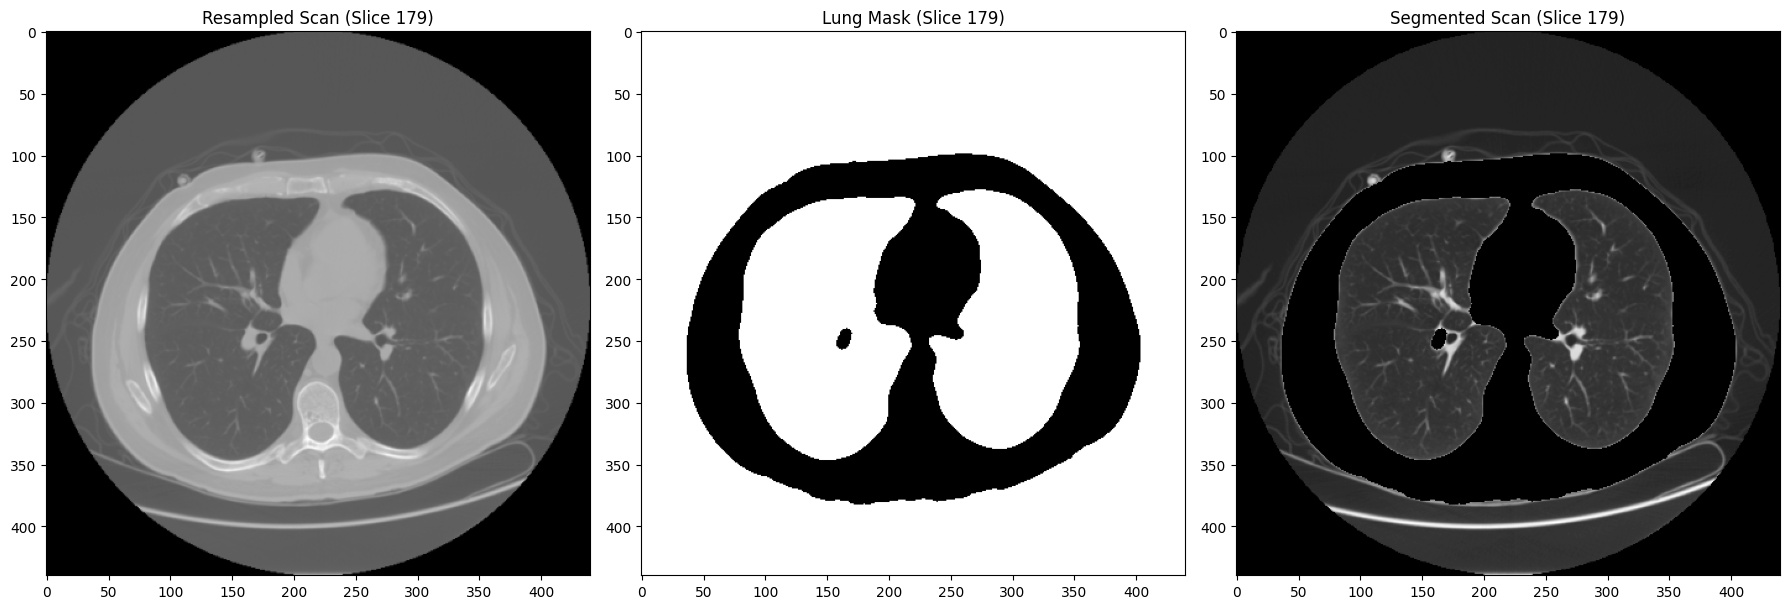

In [ ]:
if all_scan_files:
    print("\n--- Preprocessing Example ---")
    sample_scan_path = all_scan_files[0]
    seriesuid = os.path.basename(sample_scan_path).replace('.mhd', '')
    print(f"Loading scan: {seriesuid}")

    # 1. Load Scan
    scan = load_scan(sample_scan_path)
    scan_array = sitk.GetArrayFromImage(scan) # Shape: (z, y, x)
    original_spacing = scan.GetSpacing() # Order: (x, y, z)
    original_origin = scan.GetOrigin()   # Order: (x, y, z)
    print(f"Original shape: {scan_array.shape}, spacing: {original_spacing}")

    # 2. Resample
    print(f"Resampling to spacing: {TARGET_SPACING}...")
    resampled_scan = resample_scan(scan, target_spacing=TARGET_SPACING)
    resampled_array = sitk.GetArrayFromImage(resampled_scan)
    resampled_spacing = resampled_scan.GetSpacing()
    resampled_origin = resampled_scan.GetOrigin()
    print(f"Resampled shape: {resampled_array.shape}, spacing: {resampled_spacing}")

    # 3. Normalize HU
    print("Normalizing HU values...")
    normalized_array = normalize_hu(resampled_array, CLIP_BOUNDS, NORM_BOUNDS)
    print(f"Normalized array min/max: {np.min(normalized_array):.2f}/{np.max(normalized_array):.2f}")

    # 4. Lung Segmentation (Example - Check if LUNA16 provides masks first)
    print("Attempting lung segmentation (simplified)...")
    # Check for provided mask first (common in some LUNA16 versions)
    mask_path = sample_scan_path.replace('.mhd', '_lungmask.mhd')
    if os.path.exists(mask_path):
         print("Found provided lung mask.")
         mask_sitk = load_scan(mask_path)
         # Ensure mask matches resampled scan dimensions/spacing
         mask_resampled = sitk.Resample(mask_sitk, resampled_scan, sitk.Transform(), sitk.sitkNearestNeighbor, 0, mask_sitk.GetPixelID())
         lung_mask = sitk.GetArrayFromImage(mask_resampled) > 0 # Convert to boolean
    else:
        print("Provided lung mask not found, generating rough mask...")
        # Use HU values *before* normalization for thresholding
        lung_mask = create_lung_mask(resampled_array, threshold=-400) # Use Hounsfield Units

    print(f"Lung mask shape: {lung_mask.shape}, Number of masked voxels: {np.sum(lung_mask)}")

    # 5. Apply Mask
    segmented_array = normalized_array * lung_mask
    print("Applied lung mask.")

    # 6. Get Annotations for this scan & Convert Coords
    scan_annotations = annotations_df[annotations_df['seriesuid'] == seriesuid]
    print(f"\nAnnotations for {seriesuid}: {len(scan_annotations)}")
    nodule_centers_voxel = []
    nodule_diameters = []
    if not scan_annotations.empty:
        for idx, row in scan_annotations.iterrows():
            world_coord = np.array([row['coordX'], row['coordY'], row['coordZ']])
            diameter = row['diameter_mm']
            # Convert world coords to voxel coords *in the resampled image*
            voxel_coord = world_to_voxel(world_coord, resampled_origin, resampled_spacing)
            nodule_centers_voxel.append(voxel_coord) # Format: (z, y, x)
            nodule_diameters.append(diameter / np.mean(TARGET_SPACING)) # Diameter in voxels (approx)
            print(f"  Nodule: World={world_coord}, Voxel={voxel_coord}, Diameter(mm)={diameter:.1f}, Diameter(vox)={nodule_diameters[-1]:.1f}")

    # --- Visualize a Slice ---
    slice_idx = resampled_array.shape[0] // 2
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(resampled_array[slice_idx], cmap='gray')
    plt.title(f"Resampled Scan (Slice {slice_idx})")
    plt.subplot(1, 3, 2)
    plt.imshow(lung_mask[slice_idx], cmap='gray')
    plt.title(f"Lung Mask (Slice {slice_idx})")
    plt.subplot(1, 3, 3)
    plt.imshow(segmented_array[slice_idx], cmap='gray')
    # Plot nodule centers if they fall on this slice
    for i, center_vox in enumerate(nodule_centers_voxel):
        if abs(center_vox[0] - slice_idx) < 2: # Check if nodule is close to this z-slice
             radius_vox = nodule_diameters[i] / 2
             plt.scatter(center_vox[2], center_vox[1], s=radius_vox**2, c='red', alpha=0.3) # x, y for plot
             plt.text(center_vox[2], center_vox[1], f'{nodule_diameters[i]:.1f}', color='yellow', ha='center', va='center')
    plt.title(f"Segmented Scan (Slice {slice_idx})")
    plt.tight_layout()
    plt.show()

    # --- Clean up ---
    del scan, resampled_scan, scan_array, resampled_array, normalized_array, lung_mask, segmented_array
    gc.collect()

else:
    print("No scans found in the specified subset paths.")


In [ ]:
class Luna16Dataset(Dataset):
    def __init__(self, scan_paths, annotations_df, patch_size, center_size, stride=4, is_train=True, val_split=0.1, random_seed=42):
        self.scan_paths = scan_paths
        self.annotations_df = annotations_df
        self.patch_size = np.array(patch_size) # z, y, x
        self.center_size = np.array(center_size) # z, y, x
        self.output_stride = stride
        self.output_size = self.patch_size // self.output_stride

        # Split scans into training and validation
        random.seed(random_seed)
        scan_uids = list(set([os.path.basename(p).replace('.mhd', '') for p in scan_paths]))
        random.shuffle(scan_uids)
        split_idx = int(len(scan_uids) * (1 - val_split))
        if is_train:
            self.relevant_uids = set(scan_uids[:split_idx])
            print(f"Training on {len(self.relevant_uids)} scans.")
        else:
            self.relevant_uids = set(scan_uids[split_idx:])
            print(f"Validating on {len(self.relevant_uids)} scans.")

        self.scan_paths = [p for p in scan_paths if os.path.basename(p).replace('.mhd', '') in self.relevant_uids]

        # Pre-calculate patch centers (expensive preprocessing done once)
        self.patch_centers = self._prepare_patches()

    def _prepare_patches(self):
        print("Preparing patches (this may take time)...")
        patch_centers = [] # Store tuples: (scan_path, center_voxel_coord, is_positive)

        processed_count = 0
        total_scans = len(self.scan_paths)

        for scan_path in self.scan_paths:
            seriesuid = os.path.basename(scan_path).replace('.mhd', '')
            start_time = time.time()

            try:
                # --- Load and Preprocess ---
                scan = load_scan(scan_path)
                resampled_scan = resample_scan(scan, target_spacing=TARGET_SPACING)
                resampled_array = sitk.GetArrayFromImage(resampled_scan)
                normalized_array = normalize_hu(resampled_array, CLIP_BOUNDS, NORM_BOUNDS)

                # --- Lung Mask ---
                mask_path = scan_path.replace('.mhd', '_lungmask.mhd')
                if os.path.exists(mask_path):
                    mask_sitk = load_scan(mask_path)
                    mask_resampled = sitk.Resample(mask_sitk, resampled_scan, sitk.Transform(), sitk.sitkNearestNeighbor, 0, mask_sitk.GetPixelID())
                    lung_mask = sitk.GetArrayFromImage(mask_resampled) > 0
                else:
                    lung_mask = create_lung_mask(resampled_array, threshold=-400)

                segmented_array = normalized_array * lung_mask

                # --- Find Nodule Centers in this Scan ---
                scan_annotations = self.annotations_df[self.annotations_df['seriesuid'] == seriesuid]
                nodule_centers_voxel = []
                if not scan_annotations.empty:
                    resampled_origin = resampled_scan.GetOrigin()
                    resampled_spacing = resampled_scan.GetSpacing()
                    for idx, row in scan_annotations.iterrows():
                        world_coord = np.array([row['coordX'], row['coordY'], row['coordZ']])
                        voxel_coord = world_to_voxel(world_coord, resampled_origin, resampled_spacing)
                        # Check if center is within bounds
                        if np.all(voxel_coord >= 0) and np.all(voxel_coord < segmented_array.shape):
                             nodule_centers_voxel.append(tuple(voxel_coord)) # z, y, x

                # --- Generate Positive Patches ---
                for center_vox in nodule_centers_voxel:
                    # Add positive patch centered on the nodule
                    patch_centers.append((scan_path, tuple(center_vox), True))

                # --- Generate Negative Patches ---
                # Sample random locations within the lung mask, avoiding nodules
                num_negative_samples = len(nodule_centers_voxel) * 3 + 5 # Sample more negatives
                potential_neg_indices = np.argwhere(lung_mask > 0) # Indices where mask is True
                np.random.shuffle(potential_neg_indices)

                count_neg = 0
                min_dist_to_nodule = (np.max(self.patch_size) // 2) # Ensure negatives are far from positives

                for neg_idx in potential_neg_indices:
                    neg_center = tuple(neg_idx) # z, y, x

                    # Check distance to known nodules
                    is_close_to_nodule = False
                    if nodule_centers_voxel:
                       for pos_center in nodule_centers_voxel:
                           dist = np.linalg.norm(np.array(neg_center) - np.array(pos_center))
                           if dist < min_dist_to_nodule:
                               is_close_to_nodule = True
                               break
                    if is_close_to_nodule:
                       continue

                    # Check if patch fits within bounds (simplified check)
                    patch_half = self.patch_size // 2
                    if np.all(neg_center >= patch_half) and \
                       np.all(neg_center < (np.array(segmented_array.shape) - patch_half)):
                           patch_centers.append((scan_path, neg_center, False))
                           count_neg += 1
                           if count_neg >= num_negative_samples:
                               break

                processed_count += 1
                elapsed = time.time() - start_time
                print(f"  Processed {seriesuid} ({processed_count}/{total_scans}) - {len(nodule_centers_voxel)} nodules. Time: {elapsed:.2f}s")

            except Exception as e:
                print(f"!!! ERROR processing {seriesuid}: {e}")
                continue # Skip scan on error

        print(f"Finished preparing patches. Total patches: {len(patch_centers)}")
        return patch_centers

    def __len__(self):
        return len(self.patch_centers)

    def __getitem__(self, idx):
        scan_path, center_voxel, is_positive = self.patch_centers[idx]

        try:
            # --- Load Scan Data (cached or re-load) ---
            # In a real scenario, pre-processing and saving arrays might be better
            scan = load_scan(scan_path)
            resampled_scan = resample_scan(scan, target_spacing=TARGET_SPACING)
            resampled_array = sitk.GetArrayFromImage(resampled_scan)
            normalized_array = normalize_hu(resampled_array, CLIP_BOUNDS, NORM_BOUNDS)

            mask_path = scan_path.replace('.mhd', '_lungmask.mhd')
            if os.path.exists(mask_path):
                 mask_sitk = load_scan(mask_path)
                 mask_resampled = sitk.Resample(mask_sitk, resampled_scan, sitk.Transform(), sitk.sitkNearestNeighbor, 0, mask_sitk.GetPixelID())
                 lung_mask = sitk.GetArrayFromImage(mask_resampled) > 0
            else:
                 lung_mask = create_lung_mask(resampled_array, threshold=-400)

            segmented_array = normalized_array * lung_mask
            img_shape = segmented_array.shape # z, y, x

            # --- Extract Patch ---
            patch_half = self.patch_size // 2
            patch_start = np.array(center_voxel) - patch_half
            patch_end = patch_start + self.patch_size

            # Handle boundary conditions by padding
            padding = [(0,0)] * 3 # z, y, x padding (before, after)
            for i in range(3):
                if patch_start[i] < 0:
                    padding[i] = (-patch_start[i], 0)
                    patch_start[i] = 0
                if patch_end[i] > img_shape[i]:
                    padding[i] = (padding[i][0], patch_end[i] - img_shape[i])
                    patch_end[i] = img_shape[i]

            # Ensure indices are integers for slicing
            patch_start = patch_start.astype(int)
            patch_end = patch_end.astype(int)

            # Extract the available part of the patch
            image_patch = segmented_array[patch_start[0]:patch_end[0],
                                          patch_start[1]:patch_end[1],
                                          patch_start[2]:patch_end[2]]

            # Apply padding if needed
            if np.any(padding):
                image_patch = np.pad(image_patch, padding, mode='constant', constant_values=NORM_BOUNDS[0])

            # --- Create Target Heatmap ---
            target_heatmap = np.zeros(self.output_size, dtype=np.float32) # Smaller size due to stride
            if is_positive:
                # Mark the central region of the output heatmap as positive (1.0)
                center_output = self.output_size // 2
                center_half_output = (self.center_size // self.output_stride) // 2

                 # --- Potential ERROR SOURCE ---
                # Original calculation:
                # z_min, y_min, x_min = np.maximum(0, center_output - center_half_output)
                # z_max, y_max, x_max = np.minimum(self.output_size, center_output + center_half_output)
                #
                # target_heatmap[z_min[0]:z_max[0], y_min[1]:y_max[1], x_min[2]:x_max[2]] = 1.0
                # --- End Potential ERROR SOURCE ---
                  # --- CORRECTED LOGIC ---
                # Calculate start/end coords relative to heatmap center
                start_coords_relative = center_output - center_half_output
                end_coords_relative = center_output + center_half_output

                # Clip coordinates to be within heatmap bounds [0, output_size)
                # Ensure results are integer indices for slicing
                final_start_coords = np.maximum(0, start_coords_relative).astype(int)
                final_end_coords = np.minimum(self.output_size, end_coords_relative).astype(int)
                # Check if start coords are less than end coords (handle edge cases)
                if np.all(final_start_coords < final_end_coords):
                    # Slice the heatmap using the calculated coordinates
                    target_heatmap[final_start_coords[0]:final_end_coords[0],
                                   final_start_coords[1]:final_end_coords[1],
                                   final_start_coords[2]:final_end_coords[2]] = 1.0
                else:
                    # Handle cases where the positive region is too small or outside bounds
                    # E.g., print a warning or skip setting to 1.0
                    # print(f"Warning: Skipping positive heatmap region for {scan_path}, center {center_voxel} due to invalid bounds.")
                    # Optionally, mark just the center pixel if start==end
                    center_pix = center_output.astype(int)
                    if np.all(center_pix >= 0) and np.all(center_pix < self.output_size):
                         target_heatmap[center_pix[0], center_pix[1], center_pix[2]] = 1.0


            # Add channel dimension and convert to tensor
            image_patch = torch.from_numpy(image_patch).unsqueeze(0) # Add channel dim -> (1, Z, Y, X)
            target_heatmap = torch.from_numpy(target_heatmap).unsqueeze(0) # Add channel dim -> (1, z', y', x')

            return image_patch, target_heatmap

        except Exception as e:
            print(f"!!! ERROR loading patch index {idx} (scan: {scan_path}, center: {center_voxel}): {e}")
            # Return dummy data or skip
            dummy_img = torch.zeros((1, *self.patch_size), dtype=torch.float32)
            dummy_target = torch.zeros((1, *self.output_size), dtype=torch.float32)
            return dummy_img, dummy_target



In [ ]:
print("Initializing Training Dataset...")
train_dataset = Luna16Dataset(all_scan_files, annotations_df, PATCH_SIZE, CENTER_SIZE, stride=OUTPUT_STRIDE, is_train=True, val_split=VAL_SPLIT)
print("Initializing Validation Dataset...")
val_dataset = Luna16Dataset(all_scan_files, annotations_df, PATCH_SIZE, CENTER_SIZE, stride=OUTPUT_STRIDE, is_train=False, val_split=VAL_SPLIT)

Initializing Training Dataset...
Training on 4 scans.
Preparing patches (this may take time)...
  Processed 1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408431413578140925249 (1/4) - 1 nodules. Time: 110.23s
  Processed 1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094 (2/4) - 0 nodules. Time: 27.90s
  Processed 1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437 (3/4) - 8 nodules. Time: 73.83s
  Processed 1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402 (4/4) - 1 nodules. Time: 194.80s
Finished preparing patches. Total patches: 60
Initializing Validation Dataset...
Validating on 1 scans.
Preparing patches (this may take time)...
  Processed 1.3.6.1.4.1.14519.5.2.1.6279.6001.114914167428485563471327801935 (1/1) - 2 nodules. Time: 38.51s
Finished preparing patches. Total patches: 13


In [ ]:
if len(train_dataset) > 0:
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
else:
    print("Training dataset is empty!")
    train_loader = None

if len(val_dataset) > 0:
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
else:
    print("Validation dataset is empty!")
    val_loader = None


--- Sample Batch Check ---
Sample Image Batch Shape: torch.Size([2, 1, 96, 96, 96])
Sample Target Batch Shape: torch.Size([2, 1, 24, 24, 24])


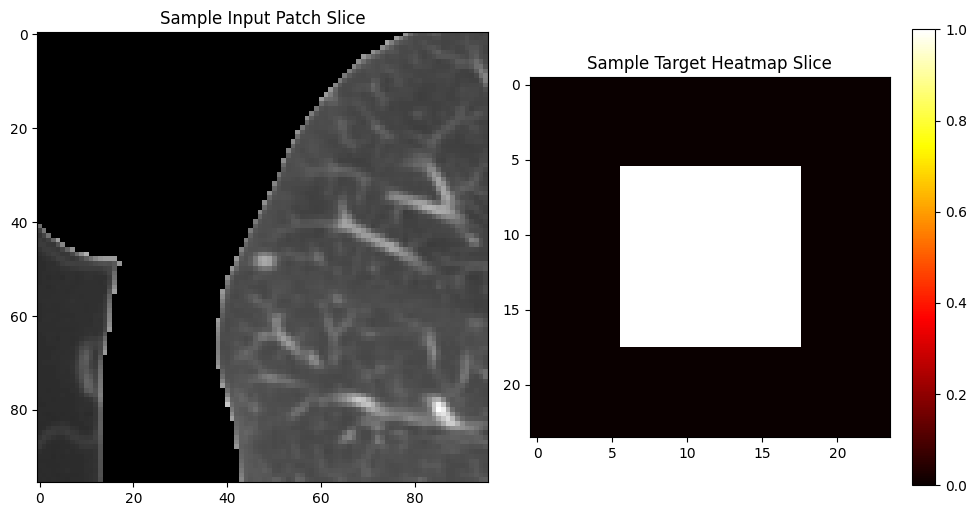

In [ ]:
if train_loader:
    print("\n--- Sample Batch Check ---")
    try:
        sample_batch_img, sample_batch_target = next(iter(train_loader))
        print("Sample Image Batch Shape:", sample_batch_img.shape)    # Expected: (B, 1, 96, 96, 96)
        print("Sample Target Batch Shape:", sample_batch_target.shape) # Expected: (B, 1, 24, 24, 24)

        # Visualize a slice from the first sample in the batch
        img_slice = sample_batch_img[0, 0, PATCH_SIZE[0]//2, :, :].numpy()
        target_slice = sample_batch_target[0, 0, (PATCH_SIZE[0]//OUTPUT_STRIDE)//2, :, :].numpy()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img_slice, cmap='gray')
        plt.title("Sample Input Patch Slice")
        plt.subplot(1, 2, 2)
        plt.imshow(target_slice, cmap='hot', vmin=0, vmax=1)
        plt.title("Sample Target Heatmap Slice")
        plt.colorbar()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error getting sample batch: {e}")
else:
    print("Cannot check sample batch: train_loader is None.")

In [ ]:
class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)


    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        return x

class EncoderBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = ConvBlock3D(in_channels, out_channels)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2) # Halves dimensions

    def forward(self, x):
        skip = self.conv_block(x)
        pooled = self.pool(skip)
        return pooled, skip

class DecoderBlock3D(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        # Upsample and reduce channels
        self.upconv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        # Concatenate skip connection, then convolve
        self.conv_block = ConvBlock3D(out_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        # Ensure spatial dimensions match for concatenation (can happen with odd input sizes)
        diffZ = skip.size()[2] - x.size()[2]
        diffY = skip.size()[3] - x.size()[3]
        diffX = skip.size()[4] - x.size()[4]
        x = nn.functional.pad(x, [diffX // 2, diffX - diffX // 2,
                                  diffY // 2, diffY - diffY // 2,
                                  diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x, skip], dim=1) # Concatenate along channel dimension
        x = self.conv_block(x)
        return x

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super().__init__()


        features = init_features
        # Encoder Path
        self.enc1 = EncoderBlock3D(in_channels, features)       # 32
        self.enc2 = EncoderBlock3D(features, features * 2)      # 64
        self.enc3 = EncoderBlock3D(features * 2, features * 4)   # 128
        self.enc4 = EncoderBlock3D(features * 4, features * 8)   # 256

        # Bottleneck
        self.bottleneck = ConvBlock3D(features * 8, features * 16) # 512

        # Decoder Path (upsampling reduces channels by factor of 2 before concat)
        self.dec4 = DecoderBlock3D(features * 16, features * 8, features * 8) # Input 512, Skip 256 -> Output 256
        self.dec3 = DecoderBlock3D(features * 8, features * 4, features * 4)  # Input 256, Skip 128 -> Output 128
        self.dec2 = DecoderBlock3D(features * 4, features * 2, features * 2)  # Input 128, Skip 64  -> Output 64
        self.dec1 = DecoderBlock3D(features * 2, features, features)           # Input 64,  Skip 32  -> Output 32

        # Final Convolution
        self.final_conv = nn.Conv3d(features, out_channels, kernel_size=1)
        # ✅ Add downsampling to match target size
        self.downsample_output = nn.AvgPool3d(kernel_size=4)

    def forward(self, x):
        enc1_pool, enc1_skip = self.enc1(x)
        enc2_pool, enc2_skip = self.enc2(enc1_pool)
        enc3_pool, enc3_skip = self.enc3(enc2_pool)
        enc4_pool, enc4_skip = self.enc4(enc3_pool)

        bottleneck = self.bottleneck(enc4_pool)

        dec4 = self.dec4(bottleneck, enc4_skip)
        dec3 = self.dec3(dec4, enc3_skip)
        dec2 = self.dec2(dec3, enc2_skip)
        dec1 = self.dec1(dec2, enc1_skip)

        output = self.final_conv(dec1)
        # Apply sigmoid to get probabilities in [0, 1] range for heatmap
        output = torch.sigmoid(output)
        output = self.downsample_output(output)
        return output

# %% [code]
# --- Instantiate Model ---
model = UNet3D(in_channels=1, out_channels=1, init_features=16).to(DEVICE) # Start with fewer features if memory is tight

# --- Test with dummy input ---
try:
    dummy_input = torch.randn(1, 1, *PATCH_SIZE, device=DEVICE) # (B, C, Z, Y, X)
    output = model(dummy_input)
    print("Model Instantiated.")
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}") # Should match target heatmap shape: (B, 1, Z/stride, Y/stride, X/stride)
    # Check if output size matches expected heatmap size
    expected_output_size = tuple(np.array(PATCH_SIZE) // OUTPUT_STRIDE)
    assert output.shape[2:] == expected_output_size, \
        f"Output size {output.shape[2:]} doesn't match expected {expected_output_size}"
    print("Output shape matches expected target heatmap shape.")
    # Clean up dummy tensor
    del dummy_input, output
    gc.collect()
    if DEVICE.type == 'cuda':
         torch.cuda.empty_cache()
except Exception as e:
    print(f"Error testing model instantiation: {e}")

Model Instantiated.
Input shape: torch.Size([1, 1, 96, 96, 96])
Output shape: torch.Size([1, 1, 24, 24, 24])
Output shape matches expected target heatmap shape.


In [ ]:
if train_loader:
    _, sample_target = next(iter(train_loader))
    pos = torch.sum(sample_target == 1.0)
    neg = torch.sum(sample_target == 0.0)
    # Avoid division by zero
    pos_weight_val = neg / (pos + 1e-6) if pos > 0 else torch.tensor(1.0)
    pos_weight = torch.tensor([pos_weight_val], device=DEVICE)
    print(f"Calculated Pos Weight for BCEWithLogitsLoss: {pos_weight.item():.2f}")
else:
    pos_weight = torch.tensor([1.0], device=DEVICE) # Default if no data
    print("Warning: No training data to calculate BCE pos_weight. Using default 1.0.")

Calculated Pos Weight for BCEWithLogitsLoss: 1.00



--- Starting Training ---
  Epoch [1/3], Batch [20/30], Loss: 0.5825
Epoch [1/3] - Time: 1712.07s - Train Loss: 0.5970, Val Loss: 0.5520
  Epoch [2/3], Batch [20/30], Loss: 0.5512
Epoch [2/3] - Time: 1841.20s - Train Loss: 0.5441, Val Loss: 0.5143
  Epoch [3/3], Batch [20/30], Loss: 0.5148
Epoch [3/3] - Time: 1740.13s - Train Loss: 0.5178, Val Loss: 0.5029
--- Training Finished ---


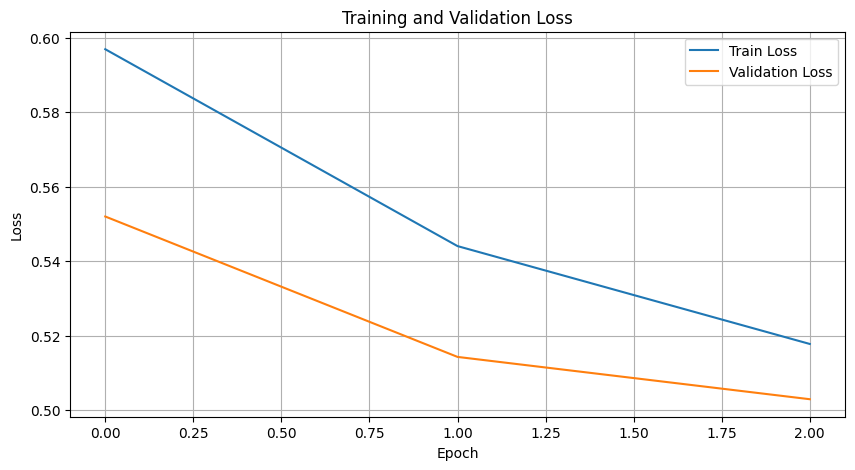

In [ ]:
class UNet3DLogits(UNet3D):  # Inherit from UNet3D
    def __init__(self, in_channels=1, out_channels=1, init_features=16):
        super().__init__(in_channels, out_channels, init_features)
        # Add downsampling layer to reduce output resolution to match target shape
        self.downsample_output = nn.AvgPool3d(kernel_size=OUTPUT_STRIDE)

    def forward(self, x):
        enc1_pool, enc1_skip = self.enc1(x)
        enc2_pool, enc2_skip = self.enc2(enc1_pool)
        enc3_pool, enc3_skip = self.enc3(enc2_pool)
        enc4_pool, enc4_skip = self.enc4(enc3_pool)
        bottleneck = self.bottleneck(enc4_pool)
        dec4 = self.dec4(bottleneck, enc4_skip)
        dec3 = self.dec3(dec4, enc3_skip)
        dec2 = self.dec2(dec3, enc2_skip)
        dec1 = self.dec1(dec2, enc1_skip)
        output_logits = self.final_conv(dec1)  # Raw logits

        # 🔧 Downsample to match target shape
        output_logits = self.downsample_output(output_logits)
        return output_logits

# Re-instantiate model to output logits
model = UNet3DLogits(in_channels=1, out_channels=1, init_features=16).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Optional: Learning rate scheduler (like the paper's decay)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1) # Example

# --- Training Loop ---
history = {'train_loss': [], 'val_loss': []}

print("\n--- Starting Training ---")
if train_loader and val_loader:
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        epoch_start_time = time.time()

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(inputs) # Outputs are logits
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # Optional: Print progress within epoch
            if (i + 1) % 20 == 0: # Print every 20 batches
                 print(f'  Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # --- Epoch End ---
        epoch_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_loss)

        # --- Validation ---
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_running_loss += loss.item()

        val_epoch_loss = val_running_loss / len(val_loader)
        history['val_loss'].append(val_epoch_loss)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Time: {epoch_duration:.2f}s - Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")

        # Optional: Update learning rate scheduler
        # scheduler.step()

        # Optional: Monitor GPU memory
        # if GPUtil and DEVICE.type == 'cuda':
        #     GPUtil.showUtilization()
        # Clear cache if needed
        if DEVICE.type == 'cuda':
            torch.cuda.empty_cache()
        gc.collect()

    print("--- Training Finished ---")

    # --- Plot Training History ---
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Cannot start training: DataLoaders are not available.")


--- Generating Candidates on Validation Set ---
  Found 1 candidates in validation sample 0


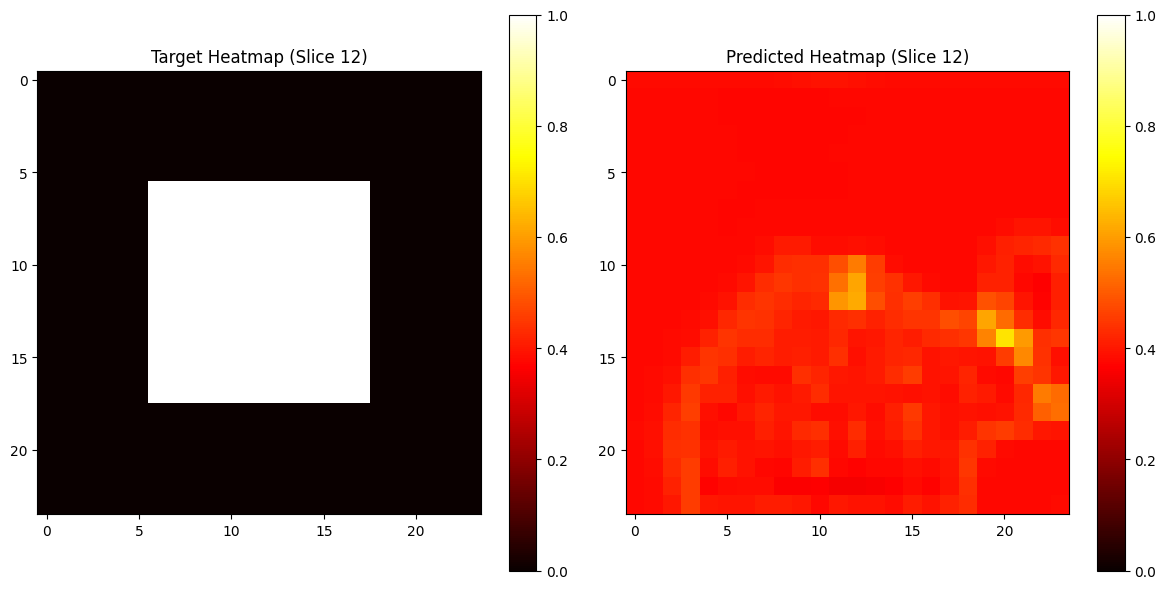

  Found 1 candidates in validation sample 2
  Found 2 candidates in validation sample 3
  Found 2 candidates in validation sample 4
  Found 1 candidates in validation sample 5
  Found 6 candidates in validation sample 6
  Found 1 candidates in validation sample 7
  Found 1 candidates in validation sample 8
  Found 1 candidates in validation sample 9
  Found 5 candidates in validation sample 10
  Found 1 candidates in validation sample 11

Total candidates generated (before coordinate conversion): 22
        seriesuid  coordX  coordY  coordZ  radius_mm  probability  \
0  unknown_scan_0      80      56      52        5.0     0.742082   
1  unknown_scan_2      36       4      32        5.0     0.793449   
2  unknown_scan_3       4      60      28        5.0     0.779847   
3  unknown_scan_3      12      60      12        5.0     0.744782   
4  unknown_scan_4      40      80      80        5.0     0.711441   

                coord_type  
0  relative_voxel_in_patch  
1  relative_voxel_in_p

In [ ]:
def find_heatmap_peaks(heatmap, threshold, min_distance_voxels):
    """Finds peaks in a 3D heatmap above a threshold, applying NMS."""
    peaks = []
    # Use a maximum filter to find local maxima
    footprint = generate_binary_structure(3, 2) # Connectivity for max filter
    local_max = (heatmap == zoom(heatmap, 1, order=0, mode='nearest')) # Simple local check or use morphology.maximum_filter

    coords = np.argwhere((heatmap > threshold) & local_max) # Indices (z, y, x) where value > threshold and is local max
    values = heatmap[coords[:, 0], coords[:, 1], coords[:, 2]]

    if len(coords) == 0:
        return []

    # Sort by probability (descending)
    sorted_indices = np.argsort(values)[::-1]
    coords_sorted = coords[sorted_indices]
    values_sorted = values[sorted_indices]

    # Non-Maximum Suppression (NMS) - simple version
    suppressed = np.zeros(len(coords_sorted), dtype=bool)
    for i in range(len(coords_sorted)):
        if suppressed[i]:
            continue
        # Keep this peak
        peaks.append((tuple(coords_sorted[i]), values_sorted[i])) # (z,y,x), probability
        # Suppress nearby peaks
        for j in range(i + 1, len(coords_sorted)):
            if suppressed[j]:
                continue
            dist = np.linalg.norm(coords_sorted[i] - coords_sorted[j])
            if dist < min_distance_voxels:
                suppressed[j] = True

    return peaks # List of tuples: ((z, y, x), probability)


# --- Predict on Validation Set and Generate Candidates ---
all_candidates = [] # Store results as list of dicts

if val_loader:
    print("\n--- Generating Candidates on Validation Set ---")
    model.eval()
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(val_loader): # Using val_loader for convenience
            # Get scan info associated with this batch (needs modification to dataset/dataloader)
            # For now, we'll just process the patch predictions
            inputs = inputs.to(DEVICE)
            output_logits = model(inputs)
            output_probs = torch.sigmoid(output_logits) # Convert logits to probabilities

            # Process each sample in the batch
            for batch_idx in range(output_probs.shape[0]):
                 heatmap = output_probs[batch_idx, 0].cpu().numpy() # (z', y', x') heatmap

                 # Find peaks in the heatmap
                 peaks = find_heatmap_peaks(heatmap, DETECTION_THRESHOLD, NMS_THRESHOLD_VOXELS / OUTPUT_STRIDE) # Adjust NMS threshold for output stride

                 if peaks:
                     print(f"  Found {len(peaks)} candidates in validation sample {i*BATCH_SIZE + batch_idx}")
                     # Get original scan path and center for coordinate conversion (NEED TO ADD TO DATASET __getitem__)
                     # scan_path, patch_center_vox, _ = val_dataset.patch_centers[i*BATCH_SIZE + batch_idx] # Example access
                     # seriesuid = os.path.basename(scan_path).replace('.mhd','')
                     # This part requires modifying the dataset to return metadata or recalculating it here

                     # --- Placeholder for Coordinate Conversion ---
                     # This section needs the original scan's origin/spacing and the patch's top-left corner
                     # to convert peak coordinates (relative to heatmap/patch) back to world coordinates.
                     # For demonstration, we'll just list the relative coords and probabilities.
                     for peak_coord_relative_heatmap, prob in peaks:
                         # 1. Scale peak coords to patch space
                         peak_coord_relative_patch = np.array(peak_coord_relative_heatmap) * OUTPUT_STRIDE
                         # 2. Add patch top-left corner offset (needs access to patch_start from __getitem__)
                         # peak_coord_absolute_scan_vox = peak_coord_relative_patch + patch_start_vox
                         # 3. Convert absolute voxel coord in scan to world coord
                         # world_coord = voxel_to_world(peak_coord_absolute_scan_vox, scan_origin, scan_spacing)
                         # 4. Estimate radius (e.g., fixed or based on heatmap intensity/spread)
                         estimated_radius_mm = 5.0 # Placeholder

                         # Add placeholder candidate
                         candidate_info = {
                             'seriesuid': f'unknown_scan_{i*BATCH_SIZE + batch_idx}', # Placeholder
                             'coordX': peak_coord_relative_patch[2], # Placeholder (relative X in patch)
                             'coordY': peak_coord_relative_patch[1], # Placeholder (relative Y in patch)
                             'coordZ': peak_coord_relative_patch[0], # Placeholder (relative Z in patch)
                             'radius_mm': estimated_radius_mm,
                             'probability': prob,
                             'coord_type': 'relative_voxel_in_patch' # Indicate coords are not world coords yet
                         }
                         all_candidates.append(candidate_info)

                 # Visualize prediction for the first sample of the first batch
                 if i == 0 and batch_idx == 0:
                     target_heatmap = targets[batch_idx, 0].cpu().numpy()
                     slice_idx = heatmap.shape[0] // 2
                     plt.figure(figsize=(12, 6))
                     plt.subplot(1, 2, 1)
                     plt.imshow(target_heatmap[slice_idx], cmap='hot', vmin=0, vmax=1)
                     plt.title(f"Target Heatmap (Slice {slice_idx})")
                     plt.colorbar()
                     plt.subplot(1, 2, 2)
                     plt.imshow(heatmap[slice_idx], cmap='hot', vmin=0, vmax=1)
                     plt.title(f"Predicted Heatmap (Slice {slice_idx})")
                     # Plot peaks found on this slice
                     for peak_coord, prob in peaks:
                         if peak_coord[0] == slice_idx:
                             plt.scatter(peak_coord[2], peak_coord[1], s=20, c='cyan', marker='x') # x, y for plot
                     plt.colorbar()
                     plt.tight_layout()
                     plt.show()


    print(f"\nTotal candidates generated (before coordinate conversion): {len(all_candidates)}")
    if all_candidates:
        candidates_df = pd.DataFrame(all_candidates)
        print(candidates_df.head())
        # Save candidates (optional)
        # candidates_df.to_csv("detected_candidates_relative.csv", index=False)

else:
    print("Cannot evaluate: Validation DataLoader not available.")


# %% [markdown]
# ## 7. Final Notes and Limitations
#
# *   **Simplifications:** This notebook uses a 3D U-Net for heatmap prediction, simplifying the paper's 3D Faster R-CNN with MSA blocks. The coordinate conversion from heatmap peaks back to world coordinates requires careful implementation (linking predictions back to the original scan and patch location), which is simplified here.
# *   **Preprocessing:** Generating patches and preprocessing LUNA16 is computationally intensive and time-consuming. Consider preprocessing and saving the results offline for faster iteration.
# *   **Lung Masking:** The provided `create_lung_mask` is basic. Using pre-computed masks from LUNA16 (if available) or more advanced segmentation methods is recommended.
# *   **Training:** Only a few epochs were run for demonstration. Proper training requires significantly more epochs and potentially hyperparameter tuning.
# *   **Candidate Output:** The final candidate list currently uses coordinates relative to the patch. A full implementation needs to convert these to absolute world coordinates (X, Y, Z) as required. Radius estimation is also simplified.
# *   **Evaluation:** True evaluation requires matching detected candidates against the ground truth `annotations.csv` using metrics like FROC or CPM, which is complex and not implemented here.
# *   **Memory:** 3D operations are memory-heavy. Adjust `BATCH_SIZE` and `init_features` based on available GPU memory.
